## Importing necessary libraries

In [37]:
from google.colab import drive

## only for gpu machine ..
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [38]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [39]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Re-size all Image Size

In [40]:
IMAGE_SIZE = [224,224]

In [41]:
train_path = 'drive/My Drive/Dataset/Cotton Disease/train'
test_path = 'drive/My Drive/Dataset/Cotton Disease/test'

## Resnet 50

In [42]:
resnet50=ResNet50(input_shape=IMAGE_SIZE + [3],weights='imagenet',include_top=False)

In [43]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [44]:
# don't train existing weights
for layer in resnet50.layers:
    layer.trainable = False

In [45]:
## useful for getting number of output classes
folder = glob(train_path+"/*")

In [46]:
# our layers - you can add more if you want
x = Flatten()(resnet50.output)

In [47]:
prediction= Dense(len(folder),activation='softmax')(x)

In [48]:
## Create Model Object
model = Model(inputs=resnet50.input,outputs = prediction)

In [49]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

## tell the model what cost and optimization method to use

In [50]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [51]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [52]:

# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1951 images belonging to 4 classes.


In [53]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 18 images belonging to 4 classes.


In [54]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/20
61/61 [==============================] - 41s 678ms/step - loss: 2.4347 - accuracy: 0.3988 - val_loss: 1.4528 - val_accuracy: 0.6111
Epoch 2/20
61/61 [==============================] - 38s 617ms/step - loss: 0.9695 - accuracy: 0.6074 - val_loss: 0.8578 - val_accuracy: 0.6111
Epoch 3/20
61/61 [==============================] - 39s 641ms/step - loss: 1.0182 - accuracy: 0.5925 - val_loss: 0.8916 - val_accuracy: 0.6667
Epoch 4/20
61/61 [==============================] - 39s 640ms/step - loss: 0.9931 - accuracy: 0.6238 - val_loss: 1.1652 - val_accuracy: 0.6111
Epoch 5/20
61/61 [==============================] - 38s 630ms/step - loss: 0.9706 - accuracy: 0.6351 - val_loss: 0.9701 - val_accuracy: 0.6667
Epoch 6/20
61/61 [==============================] - 38s 624ms/step - loss: 0.7864 - accuracy: 0.6807 - val_loss: 0.9932 - val_accuracy: 0.6111
Epoch 7/20
61/61 [==============================] - 38s 625ms/step - loss: 0.8485 - accuracy: 0.6709 - val_loss: 0.6134 - val_accuracy: 0.6667

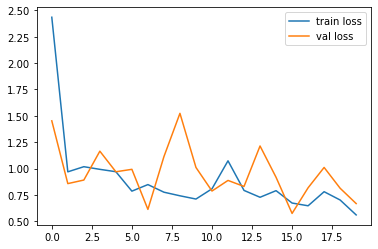

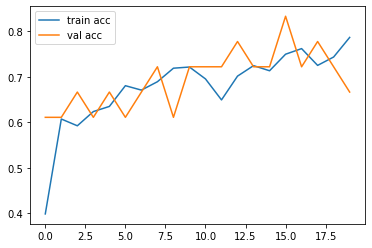

<Figure size 432x288 with 0 Axes>

In [55]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [56]:
from tensorflow.keras.models import load_model

model.save('model_resenet.h5')

## InceptionV3

In [57]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [58]:

# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [59]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [60]:

# our layers - you can add more if you want
x = Flatten()(inception.output)

In [62]:
prediction = Dense(len(folder), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [63]:
# view the structure of the model
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [64]:

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [65]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [67]:

# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1951 images belonging to 4 classes.


In [68]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 18 images belonging to 4 classes.


In [69]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/20
61/61 [==============================] - 42s 692ms/step - loss: 4.0007 - accuracy: 0.7043 - val_loss: 0.4546 - val_accuracy: 0.8889
Epoch 2/20
61/61 [==============================] - 37s 611ms/step - loss: 0.6897 - accuracy: 0.8724 - val_loss: 0.0145 - val_accuracy: 1.0000
Epoch 3/20
61/61 [==============================] - 37s 609ms/step - loss: 0.4011 - accuracy: 0.9118 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 4/20
61/61 [==============================] - 36s 598ms/step - loss: 0.5481 - accuracy: 0.9036 - val_loss: 0.1196 - val_accuracy: 0.9444
Epoch 5/20
61/61 [==============================] - 37s 607ms/step - loss: 0.5157 - accuracy: 0.9247 - val_loss: 0.1092 - val_accuracy: 0.9444
Epoch 6/20
61/61 [==============================] - 37s 605ms/step - loss: 0.3373 - accuracy: 0.9436 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 7/20
61/61 [==============================] - 37s 604ms/step - loss: 0.3180 - accuracy: 0.9405 - val_loss: 2.2337e-05 - val_accuracy: 1.

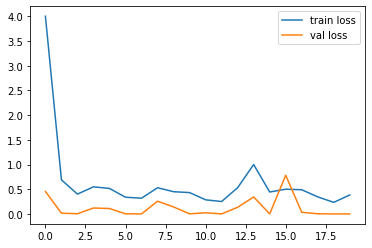

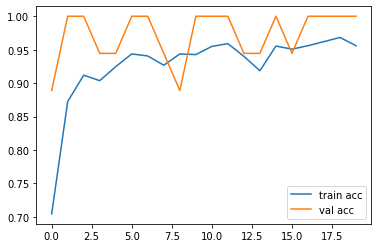

<Figure size 432x288 with 0 Axes>

In [70]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [71]:
model.save('model_inception.h5')

In [72]:
y_pred = model.predict(test_set)

In [73]:
y_pred

array([[5.60212538e-27, 1.00000000e+00, 1.00984325e-32, 0.00000000e+00],
       [4.97387774e-20, 1.00000000e+00, 1.22217221e-12, 4.51789485e-13],
       [9.79757293e-23, 0.00000000e+00, 1.00000000e+00, 2.08457924e-35],
       [2.64059279e-17, 2.44522041e-21, 1.00000000e+00, 4.84984875e-14],
       [1.54472050e-19, 2.54096692e-15, 1.00000000e+00, 9.94902307e-29],
       [1.00000000e+00, 0.00000000e+00, 1.51692425e-27, 1.49109120e-25],
       [4.72968507e-17, 2.36099340e-09, 8.43505902e-15, 1.00000000e+00],
       [1.29271930e-05, 6.29815042e-34, 9.99987125e-01, 6.74493380e-25],
       [1.00000000e+00, 3.67506319e-31, 7.74458198e-22, 0.00000000e+00],
       [4.21639408e-37, 2.71800111e-08, 1.48433607e-27, 1.00000000e+00],
       [3.65660073e-33, 1.87812534e-33, 6.65113346e-29, 1.00000000e+00],
       [3.00954146e-22, 1.00000000e+00, 1.39754341e-09, 1.32128045e-10],
       [9.15962879e-15, 1.05536330e-10, 1.33036828e-11, 1.00000000e+00],
       [1.54908085e-12, 2.57981397e-12, 8.11546108e

In [74]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [75]:
y_pred

array([1, 1, 2, 2, 2, 0, 3, 2, 0, 3, 3, 1, 3, 3, 1, 1, 2, 0])